In [1]:
import configparser
import os
from joblib import dump, load
import json
from tqdm import tqdm
from helpers.helper_functions import *
from helpers.helper_classes import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import scienceplots
import latex
import random

from sklearn.metrics import accuracy_score
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Set plotting parameters
plt.style.use(['science', 'ieee'])
plt.rcParams['figure.dpi'] = 100

pd.set_option('display.max_rows', 200)

# Read config.ini file
config = configparser.ConfigParser()
config.read('src/config.ini')

# Read data
df_og = load(config['PATH']['DATA_DIR'] + '/full_df_daily_cap95.joblib')

c:\Users\caspa\Desktop\data-mining-techniques-vu\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Construct target as bad (0-6), okay (6-8), good (8-10)
df = df_og.copy()
# df = df.drop(columns = ['time'])

# Impute outliers (larger than 1.5 IQR) with mean of column in all _sum columns
# for col in df.columns:
#     if col.endswith('_sum'):
#         df[col] = df[col].mask(df[col] > df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)), df[col].mean())

In [3]:
X, y = df.drop(columns=['target'], axis = 1), df['target']

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_ts(X, y, split_ratios=[0.5, 0.2])

# Full train set for final model
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Get non-dummy columns
if len([var for var in df.columns if var.startswith('day')]) == 7:
    df = df.drop(columns=['day_of_week_0'])
dummy_cols = [var for var in df.columns if var.startswith('day')] + ['target', 'activity_idc', 'call_idc', 'sms_idc', 'id']
cols_no_dummy = [var for var in X_train.columns if var not in dummy_cols]

# Scale data
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([('scaler', StandardScaler(), cols_no_dummy)], remainder='passthrough')
ct.set_output(transform='pandas')
X_train_scaled = ct.fit_transform(X_train)
X_val_scaled = ct.transform(X_val)


In [4]:
seq_length = 7
X_lstm_train, y_lstm_train = shape_lstm(X_train_scaled, y_train, seq_length=seq_length)
X_lstm_val, y_lstm_val = shape_lstm(X_val_scaled, y_val, seq_length=seq_length)


In [5]:
# Define the objective function for the optimization
def objective(trial: Trial):
    hidden_units = trial.suggest_int('hunits', 16, 256, step=16)
    epochs = trial.suggest_int('epochs', 5, 40, step=5)


    input_shape = (seq_length, X_lstm_train.shape[2])
    model = build_lstm_model_regression(input_shape, hidden_units)
    model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
    model.fit(X_lstm_train, y_lstm_train, epochs=epochs, batch_size=32, verbose = 0)
    score = model.evaluate(X_lstm_val, y_lstm_val, verbose=0)

    return score[0]

# Optimize the pipeline using Optuna
manual_seed = 42
np.random.seed(manual_seed)
random.seed(manual_seed)
tf.random.set_seed(manual_seed)
sampler = TPESampler(seed=manual_seed)

study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=50)

# Print the best trial
best_trial = study.best_trial
print(f"Best trial: {best_trial.number}, Accuracy: {best_trial.value}")
print(f"Best params: {best_trial.params}")


[I 2023-04-21 13:24:41,016] A new study created in memory with name: no-name-2a028fcb-6034-46da-baa0-8d82ae377bd2
[I 2023-04-21 13:24:48,558] Trial 0 finished with value: 0.40749552845954895 and parameters: {'hunits': 96, 'epochs': 40}. Best is trial 0 with value: 0.40749552845954895.
[I 2023-04-21 13:24:54,851] Trial 1 finished with value: 0.35876622796058655 and parameters: {'hunits': 192, 'epochs': 25}. Best is trial 1 with value: 0.35876622796058655.
[I 2023-04-21 13:24:58,927] Trial 2 finished with value: 0.6519469022750854 and parameters: {'hunits': 48, 'epochs': 10}. Best is trial 1 with value: 0.35876622796058655.
[I 2023-04-21 13:25:04,355] Trial 3 finished with value: 0.741898238658905 and parameters: {'hunits': 16, 'epochs': 35}. Best is trial 1 with value: 0.35876622796058655.


[I 2023-04-21 13:25:11,104] Trial 4 finished with value: 0.41475561261177063 and parameters: {'hunits': 160, 'epochs': 30}. Best is trial 1 with value: 0.35876622796058655.


[I 2023-04-21 13:25:16,351] Trial 5 finished with value: 0.627223014831543 and parameters: {'hunits': 16, 'epochs': 40}. Best is trial 1 with value: 0.35876622796058655.
[I 2023-04-21 13:25:21,001] Trial 6 finished with value: 0.38268789649009705 and parameters: {'hunits': 224, 'epochs': 10}. Best is trial 1 with value: 0.35876622796058655.
[I 2023-04-21 13:25:24,991] Trial 7 finished with value: 0.6880031228065491 and parameters: {'hunits': 48, 'epochs': 10}. Best is trial 1 with value: 0.35876622796058655.
[I 2023-04-21 13:25:30,514] Trial 8 finished with value: 0.3985042870044708 and parameters: {'hunits': 80, 'epochs': 25}. Best is trial 1 with value: 0.35876622796058655.
[I 2023-04-21 13:25:36,211] Trial 9 finished with value: 0.4029614329338074 and parameters: {'hunits': 112, 'epochs': 15}. Best is trial 1 with value: 0.35876622796058655.
[I 2023-04-21 13:25:45,599] Trial 10 finished with value: 0.3904056251049042 and parameters: {'hunits': 256, 'epochs': 20}. Best is trial 1 wit

Best trial: 45, Accuracy: 0.3545897901058197
Best params: {'hunits': 208, 'epochs': 20}


In [9]:
# Train columntransformer on full training data
ct = ColumnTransformer([('scaler', StandardScaler(), cols_no_dummy)], remainder='passthrough')
ct.set_output(transform='pandas')
X_train_full_scaled = ct.fit_transform(X_train_full)
X_test_scaled = ct.transform(X_test)

# Create sequences for LSTM
X_train_full_lstm, y_train_full_lstm = shape_lstm(X_train_full_scaled, y_train_full, seq_length=7)
X_test_lstm, y_test_lstm, naive_test = shape_lstm(X_test_scaled, y_test, seq_length=7, return_naive=True)

# Build and train the LSTM model on the full training data
input_shape = (seq_length, X_train_full_lstm.shape[2])
model2 = build_lstm_model_regression(input_shape, hunits=best_trial.params['hunits'])
model2.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
model2.summary()
hist2 = model2.fit(X_train_full_lstm, y_train_full_lstm, epochs=best_trial.params['epochs'], batch_size=32, validation_data=(X_test_lstm, y_test_lstm), verbose=1)


model3 = build_lstm_model_regression(input_shape, hunits=best_trial.params['hunits'])
model3.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])
hist3 = model3.fit(X_train_full_lstm, y_train_full_lstm, epochs=best_trial.params['epochs'], batch_size=32, validation_data=(X_test_lstm, y_test_lstm), verbose=1)
# Predict on the test set
y_pred = model2.predict(X_test_lstm)
y_pred_mae = model3.predict(X_test_lstm)
# Evaluate the model
score = model2.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print('MSE:', score[0])
print('MAE:', score[2])


Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 208)               212992    
                                                                 
 dense_52 (Dense)            (None, 1)                 209       
                                                                 
Total params: 213,201
Trainable params: 213,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
21/21 [==============================] - 3s 43ms/step - loss: 24.5422 - mse: 24.5422 - mae: 4.4053 - val_loss: 3.1456 - val_mse: 3.1456 - val_mae: 1.6011
Epoch 2/20
21/21 [==============================] - 0s 14ms/step - loss: 1.2283 - mse: 1.2283 - mae: 0.8942 - val_loss: 0.3618 - val_mse: 0.3618 - val_mae: 0.4656
Epoch 3/20
21/21 [==============================] - 0s 13ms/step - loss: 0.4274 - mse: 0.4274 - mae: 0.4947 - val_l

In [16]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

mean_pred = np.array([np.mean(y_train_full)] * len(y_test_lstm))

# Calculate the naive error
pred_dict = {'LSTM': y_pred.flatten(), 'Naive forecast': naive_test, 'Mean forecast': mean_pred}
res_dict = {}
for key, pred in pred_dict.items():
    mse = mean_squared_error(y_test_lstm.flatten(), pred)
    mae = mean_absolute_error(y_test_lstm.flatten(), pred)
    res_dict[key] = {'MSE': mse, 'MAE': mae}

# Print to dataframe round to 2 decimal places
print(pd.DataFrame(res_dict).round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
 & LSTM & Naive forecast & Mean forecast \\
\midrule
MSE & 0.298000 & 0.303000 & 0.318000 \\
MAE & 0.423000 & 0.434000 & 0.438000 \\
\bottomrule
\end{tabular}



In [8]:
plot_persons = ['AS14.06', 'AS14.25', 'AS14.32']
data_dict = {person: {} for person in plot_persons}
for person in plot_persons:
    X_cur = X_test_scaled[X_test_scaled['remainder__id'] == person].copy()
    X_cur_unscaled = X_test[X_test['id'] == person].copy()
    X_lstm, y_lstm = shape_lstm(X_cur, y_test[X_test_scaled['remainder__id'] == person], seq_length=7)
    
    data_dict[person]['LSTM_mse'] = model2.predict(X_lstm).flatten()
    data_dict[person]['LSTM_mae'] = model3.predict(X_lstm).flatten()
    data_dict[person]['naive_pred'] = X_cur_unscaled['mood_avg'][6:].copy().reset_index(drop=True)
    data_dict[person]['mean_pred'] = np.array([np.mean(y_train_full)] * len(y_lstm))
    data_dict[person]['y_true'] = y_lstm.flatten()

# MSE and MAE
metric_dict = {}
metric_dict = {person: {} for person in plot_persons}
for person in plot_persons:
    for key, pred in data_dict[person].items():
        if key != 'y_true':
            y_true = data_dict[person]['y_true']
            mse = mean_squared_error(y_true, pred)
            mae = mean_absolute_error(y_true, pred)
            metric_dict[person][key + '_mse'] = mse
            metric_dict[person][key + '_mae'] = mae

X_28_lstm, y_28_lstm = shape_lstm(X_test_28, y_test_28, seq_length=7)

1/1 [==============================] - 0s 25ms/step


NameError: name 'X_test_28' is not defined

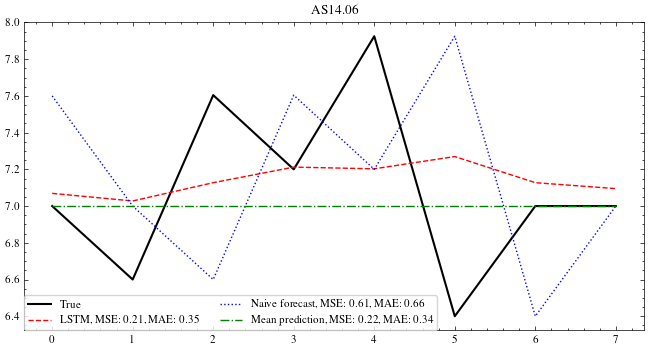

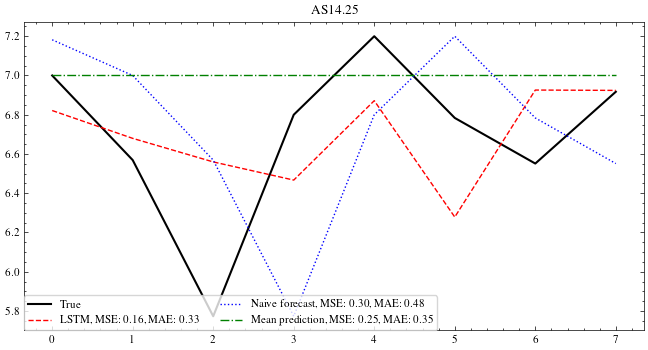

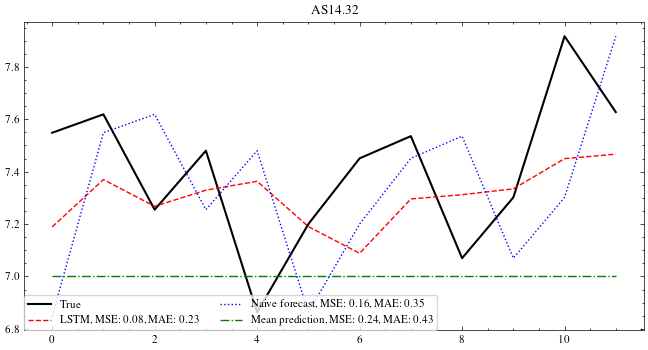

In [14]:
# visualize the prediction
for person in plot_persons:
    plt.figure(figsize=(8, 4))
    plt.plot(y_test[X_test['id'] == person][6:].reset_index(drop=True, inplace=False), label='True', linewidth = 1.5)
    plt.plot(data_dict[person]['LSTM_mse'], label=f'LSTM, MSE: {metric_dict[person]["LSTM_mse_mse"]:.2f}, MAE: {metric_dict[person]["LSTM_mse_mae"]:.2f}')
    plt.plot(data_dict[person]['naive_pred'], label=f'Naive forecast, MSE: {metric_dict[person]["naive_pred_mse"]:.2f}, MAE: {metric_dict[person]["naive_pred_mae"]:.2f}')
    plt.plot(data_dict[person]['mean_pred'], label=f'Mean prediction, MSE: {metric_dict[person]["mean_pred_mse"]:.2f}, MAE: {metric_dict[person]["mean_pred_mae"]:.2f}')

    plt.legend(loc='lower left', ncols = 2, borderaxespad=0, frameon=True, bbox_to_anchor=(0.0, 0.0))

    plt.title(person)
    plt.show()

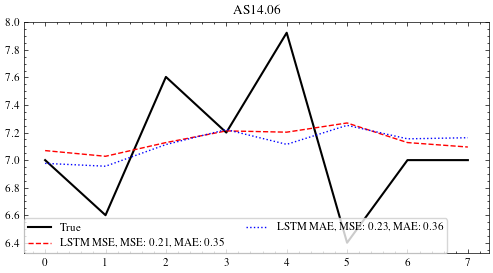

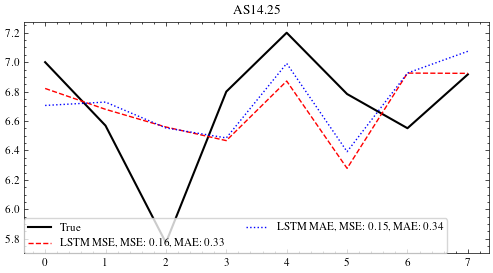

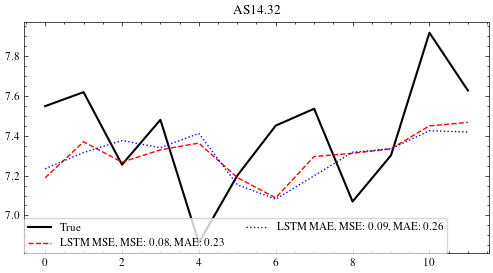

In [15]:
# Plot lstm mae vs lstm mse vs truth
for person in plot_persons:
    plt.figure(figsize=(6, 3))
    plt.plot(y_test[X_test['id'] == person][6:].reset_index(drop=True, inplace=False), label='True', linewidth = 1.5)
    plt.plot(data_dict[person]['LSTM_mse'], label=f'LSTM MSE, MSE: {metric_dict[person]["LSTM_mse_mse"]:.2f}, MAE: {metric_dict[person]["LSTM_mse_mae"]:.2f}')
    plt.plot(data_dict[person]['LSTM_mae'], label=f'LSTM MAE, MSE: {metric_dict[person]["LSTM_mae_mse"]:.2f}, MAE: {metric_dict[person]["LSTM_mae_mae"]:.2f}')
    # Legend left bottom, with backdrop
    plt.legend(loc='lower left', ncol=2, borderaxespad=0, frameon=True)
    plt.title(person)
    plt.show()